In [1]:
import pymc as pm 

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd 
import numpy as np
import arviz as az
import palmerpenguins as pp

In [3]:
penguins = pp.load_penguins()

In [4]:
missing_data = penguins.isnull()[["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]].any(axis=1)
penguins = penguins.loc[~missing_data]

In [6]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

In [14]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]

with pm.Model() as model_adelie_flipper_regression:
    # pm.Data allows us to change the underlying value in a later code block
    adelie_flipper_length = pm.Data("adelie_flipper_length",
                                    adelie_flipper_length_obs, mutable=True)
    sigma = pm.HalfStudentT("sigma", 100, 2000)
    beta_0 = pm.Normal("beta_0", 0, 4000)
    beta_1 = pm.Normal("beta_1", 0, 4000)
    mu = pm.Deterministic("mu", beta_0 + beta_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed = adelie_mass_obs)

    inf_data_adelie_flipper_regression = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_0, beta_1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.


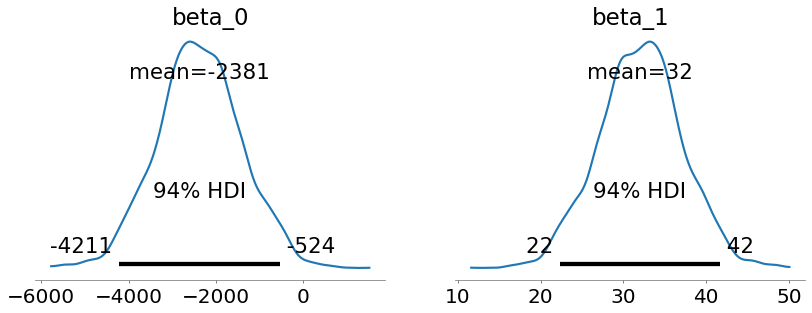

In [15]:
axes = az.plot_posterior(inf_data_adelie_flipper_regression, var_names=["beta_0", "beta_1"], textsize=20)

In [16]:
with model_adelie_flipper_regression:
    # Change the underlying value to the mean observed flipper length
    # for our posterior predictive samples
    pm.set_data({"adelie_flipper_length": [adelie_flipper_length_obs.mean()]})
    posterior_predictions = pm.sample_posterior_predictive(
        inf_data_adelie_flipper_regression.posterior, var_names=["mass", "mu"])

Sampling: [mass]


## Multiple Linear Regression

In [27]:
sex_obs = penguins.loc[adelie_mask ,"sex"].replace({"male":0, "female":1})

with pm.Model() as model_penguin_mass_categorical:
    sigma = pm.HalfStudentT("sigma", 100, 2000)
    beta_0 = pm.Normal("beta_0", 0, 3000)
    beta_1 = pm.Normal("beta_1", 0, 3000)
    beta_2 = pm.Normal("beta_2", 0, 3000)

    mu = pm.Deterministic(
        "mu", beta_0 + beta_1 * adelie_flipper_length_obs + beta_2 * sex_obs)

    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=adelie_mass_obs)

    inf_data_penguin_mass_categorical = pm.sample(
        target_accept=.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_0, beta_1, beta_2]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.


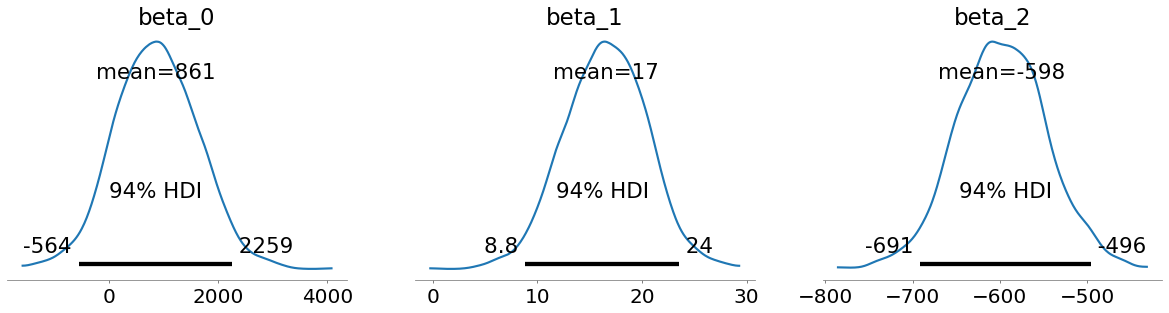

In [28]:
axes = az.plot_posterior(inf_data_penguin_mass_categorical, var_names=["beta_0", "beta_1", "beta_2"], textsize=20)

In [31]:
az.summary(inf_data_penguin_mass_categorical, var_names=["beta_0", "beta_1", "beta_2","sigma"], round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,861.362,760.514,-563.905,2258.933,20.928,14.801,1322.030,1606.591,1.001
beta_1,16.536,3.947,8.841,23.537,0.108,0.077,1333.702,1676.985,1.001
beta_2,-597.964,51.698,-691.041,-496.051,1.148,0.812,2030.903,1883.429,1.001
sigma,297.935,17.833,266.022,332.755,0.359,0.255,2491.147,2215.818,1.001


In [30]:
import bambi as bmb

model = bmb.Model("body_mass_g ~ flipper_length_mm + sex", penguins.loc[adelie_mask])
trace = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_g_sigma, Intercept, flipper_length_mm, sex]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.
